In [1]:
import torch
import torchvision
import torchvision.models as models
from torchvision.models.resnet import ResNet50_Weights
import lightning.pytorch as pl

from mymodels import Model_Wrapper, Preprocess
from myutils import View, sample_imgs_list

In [ ]:
# configs to speed up training
torch.set_float32_matmul_precision('medium')
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [2]:
PATH_TO_IMAGENET = '../../datasets/imagenet/2012/'

In [3]:
resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)
resnet50 = Model_Wrapper(resnet50)
# trainer = pl.Trainer(accelerator="auto", limit_test_batches=100)
trainer = pl.Trainer(accelerator="auto")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [4]:
def compare_ds(model, datasets, labels, view_img_slice, view_only=False, figsize=(12,6), verbose=True, skip_results:list=[0]):
    results = {}
    samples = []
    #display first
    for ds in datasets:
        samples.append(sample_imgs_list(ds, view_img_slice))
    _ = View.compare_color(samples, labels, figsize=figsize)
    
    if not view_only:
        for i in range(len(datasets)):
            if i in skip_results:
                continue
            result = trainer.test(model, datasets[i], verbose=verbose)
            results[labels[i]] = result
        return results
    else:
        return None
    

In [5]:
# get transforms
prep = Preprocess(PATH_TO_IMAGENET, (224, 224), shuffle=True)
preview_img_slice = [1, 7000, 35906, 43001, 35289]

##### Test On Orignal Dataset

<Figure size 1200x600 with 0 Axes>

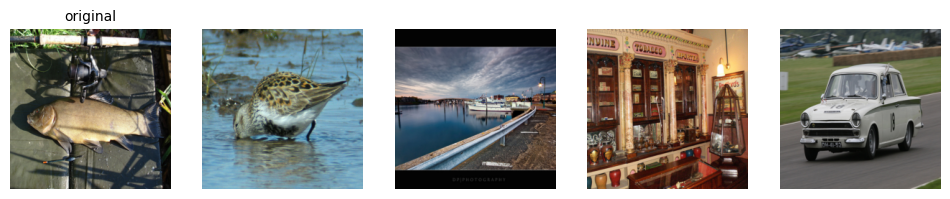

You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2023-06-27 10:42:30.215267: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-27 10:42:30.545431: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-27 10:42:31.350648: W tensorflow/stream_ex

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     38.13455581665039     │
│      Pixel Val MEAN       │    112.56639862060547     │
│       Pixel Val STD       │     54.29246520996094     │
│        Top 1 Acc %        │     78.39800262451172     │
│        Top 5 Acc %        │     94.36000061035156     │
└───────────────────────────┴───────────────────────────┘

In [6]:
prep.reset_trans()
imgnet_orig = prep.get_loader()
sample_orig = sample_imgs_list(imgnet_orig, preview_img_slice)# test model on original images
View.compare_color([sample_orig], ['original'], figsize=(12,6))
result_orig = trainer.test(resnet50, imgnet_orig)

##### Test filters on Orignal Dataset

In [7]:
prep.reset_trans()
imgnet = prep.get_loader()
imgnet_histeq = prep.copy().hist_eq().get_loader()
result_orig = trainer.test(resnet50, imgnet_histeq)

You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     36.27178955078125     │
│      Pixel Val MEAN       │    109.96653747558594     │
│       Pixel Val STD       │     68.2337417602539      │
│        Top 1 Acc %        │     74.16000366210938     │
│        Top 5 Acc %        │     91.83799743652344     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
prep.reset_trans()
imgnet = prep.get_loader()
imgnet_histeq = prep.copy().hist_eq().get_loader()
imgnet_retinex = prep.copy().retinex('SSR', 100).get_loader()
imgnet_results = compare_ds(resnet50, 
                                 [imgnet, imgnet_histeq, imgnet_retinex],
                                 ['Original', 'Original + HistEQ', 'Original + Retinex'], 
                                 preview_img_slice,
                                 view_only=False)

##### Test on Dark Images

In [ ]:
prep.reset_trans()
imgnet_dark = prep.luminance(1/8).get_loader()
imgnet_dark_histeq = prep.copy().hist_eq().get_loader()
imgnet_dark_retinex = prep.copy().retinex('SSR', 100).get_loader()
imgnet_dark_results = compare_ds(resnet50, 
                                 [prep.basic_loader(), imgnet_dark, imgnet_dark_histeq, imgnet_dark_retinex],
                                 ['Original', 'Dark', 'Dark + HistEQ', 'Dark + Retinex'], 
                                 preview_img_slice,
                                 view_only=False)

##### Test on Over Exposed Images

In [ ]:
prep.reset_trans()
imgnet_bright = prep.luminance(2).get_loader()
imgnet_bright_histeq = prep.copy().hist_eq().get_loader()
imgnet_bright_retinex = prep.copy().retinex('SSR', 100).get_loader()
imgnet_bright_results = compare_ds(resnet50, 
                                 [prep.basic_loader(), imgnet_bright, imgnet_bright_histeq, imgnet_bright_retinex],
                                 ['Original', 'Bright', 'Bright + HistEQ', 'Bright + Retinex'], 
                                 preview_img_slice)

##### Test on hazy images

In [ ]:
prep.reset_trans()
imgnet_mod = prep.fog(10).get_loader()
imgnet_mod_histeq = prep.copy().hist_eq().get_loader()
imgnet_mod_retinex = prep.copy().retinex('SSR', 100).get_loader()
imgnet_mod_results = compare_ds(resnet50, 
                                 [prep.basic_loader(), imgnet_mod, imgnet_mod_histeq, imgnet_mod_retinex],
                                 ['Original', 'Hazy / Foggy', 'Hazy + HistEQ', 'Hazy + Retinex'], 
                                 preview_img_slice,
                                 view_only=False)

##### Test on Dark Rainy Images

In [ ]:
prep.reset_trans()
imgnet_mod = prep.rain(2, 75).get_loader()
imgnet_mod_histeq = prep.copy().hist_eq().get_loader()
imgnet_mod_retinex = prep.copy().retinex('SSR', 100).get_loader()
imgnet_mod_results = compare_ds(resnet50, 
                                 [prep.basic_loader(), imgnet_mod, imgnet_mod_histeq, imgnet_mod_retinex],
                                 ['Original', 'Dark Rainy', 'Dark Rainy+ HistEQ', 'Dark Rainy + Retinex'], 
                                 preview_img_slice,
                                 view_only=False)

##### Test Histogram Eq on Low Contrast Images

In [ ]:
# prep.reset_trans()
# imgnet_low_cont = prep.brightness_contrast(0,5).get_loader()
# imgnet_low_cont_histeq = prep.copy().hist_eq().get_loader()
# imgnet_low_cont_retinex = prep.copy().retinex('SSR', 100).get_loader()
# imgnet_low_cont_results = compare_ds(resnet50, 
#                                  [prep.basic_loader(), imgnet_low_cont, imgnet_low_cont_histeq, imgnet_low_cont_retinex],
#                                  ['Original', 'Low Contrast', 'Low Contrast + HistEQ', 'Low Contrast + Retinex'], 
#                                  preview_img_slice)

##### Test Remapping Distribution to be low contrast

In [ ]:
# prep.reset_trans()
# imgnet_mod = prep.dist_remap(20/255,20/255).get_loader()
# imgnet_mod_histeq = prep.copy().hist_eq().get_loader()
# imgnet_mod_retinex = prep.copy().retinex('SSR', 100).get_loader()
# imgnet_mod_results = compare_ds(resnet50, 
#                                  [prep.basic_loader(), imgnet_mod, imgnet_mod_histeq, imgnet_mod_retinex],
#                                  ['Original', 'Low Contrast', 'Low Contrast + HistEQ', 'Low Contrast + Retinex'], 
#                                  preview_img_slice,
#                                  view_only=False)